# Graph construction and processing 

In this notebook, we will demonstrate the ability of the new pathml.graph API to construct cell and tissue graphs. Specifically, we will do the following:

1. Detect cells in the given Whole-Slide Image (WSI)
2. Detect tissues in the given WSI
3. Featurize the detected cell and tissue patches using a pre-trained ResNet-34 model
4. Construct both tissue and cell graphs using k-Nearest Neighbour (k-NN) and Region-Adjacency Graph (RAG) methods and save them as torch tensors

To get the full functionality of this notebook for a real-world dataset, we suggest you download the BRACS ROI set from the [BRACS dataset](https://www.bracs.icar.cnr.it/download/). To do so, you will have to sign up and create an account. Next, you will just have to replace the root folder in the last part of the tutorial to the directory you download the BRACS dataset to. 

In [1]:
import os
from glob import glob
import argparse
from PIL import Image
import numpy as np
from tqdm import tqdm
import torch 
import h5py
import warnings
import math
from skimage.measure import regionprops, label
import networkx as nx
import traceback
from glob import glob
import matplotlib.pyplot as plt 

from pathml.core import HESlide, Tile, types
from pathml.preprocessing import Pipeline, NucleusDetectionHE
import pathml.core.tile
from pathml.datasets.utils import DeepPatchFeatureExtractor
from pathml.graph import RAGGraphBuilder, KNNGraphBuilder
from pathml.graph import ColorMergedSuperpixelExtractor
from pathml.graph.utils import get_full_instance_map, build_assignment_matrix

fontsize = 14
device = 'cuda' # if using GPU
#device = 'cpu' # if using CPU

## Data 

In this notebook, we will use a representative image `CMU-1-Small-Region.svs.tiff` downloaded from [OpenSlide](http://openslide.cs.cmu.edu/download/openslide-testdata/Aperio/). We will then use a small tile for illustrative purposes. 

In [2]:
#wsi = HESlide("../data/target.png")
wsi = HESlide("../data/CMU-1-Small-Region.svs.tiff")

region = wsi.slide.extract_region(location = (800, 900), size = (500, 500))
region = np.squeeze(region)

def smalltile():
    # convenience function to create a new tile
    return Tile(region, coords = (0, 0), name = "testregion", slide_type = types.HE)
    
tile = smalltile()

## Nucleus Detection

Next, we will use a built-in `PathML` feature to detect cells in the given tile. 

For better results, we suggest using a pre-trained segmentation model like HoVer-Net to do the cell segmentation. HoVer-Net can be trained using `PathML` in this [tutorial](https://pathml.readthedocs.io/en/latest/examples/link_train_hovernet.html).

In [3]:
# create a NucleusDetectionHE object
nucleus_detection = NucleusDetectionHE(mask_name = "detect_cell", superpixel_region_size=10)

# apply onto our tile
nucleus_detection.apply(tile)

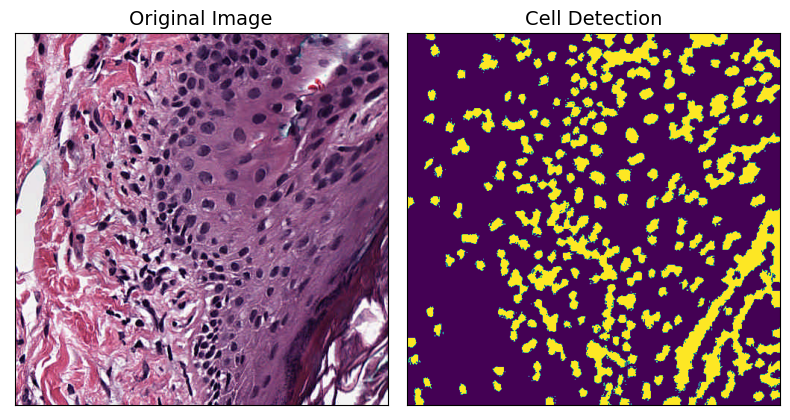

In [4]:
# plot the original and cell segmented image
fig, axarr = plt.subplots(nrows=1, ncols=2, figsize=(8, 8))
axarr[0].imshow(tile.image)
axarr[0].set_title("Original Image", fontsize=fontsize)
axarr[1].imshow(tile.masks["detect_cell"])
axarr[1].set_title("Cell Detection", fontsize=fontsize)
for ax in axarr.ravel():
    ax.set_yticks([])
    ax.set_xticks([])
plt.tight_layout()
plt.show()

## Feature Extraction

Next, we generate features for the detected cell using a pre-trained ResNet-34 model. Altough this is not needed for cell-graph construction, we include them as features in the graph for downstream training of a deep learning model. 

For each detected cell, we crop out a patch containing that cell in the center. The patches for all detected cells are fed into the pretrained ResNet-34 model to generate some useful features. Although these features are not directly related to pathology, they can be a useful startining point for helping downstream models learn. Alternatively, one could also use hand-engineered features like cell shape, eccentricity, area, etc as features.

In [5]:
# extract the image from our tile
image = tile.image

# extract the cell segmented mask from our tile
nuclei_map = tile.masks['detect_cell']

# uniquely label each cell in the mask and record the centroids for each cell
label_instance_map = label(nuclei_map)
regions = regionprops(label_instance_map)
instance_centroids = np.empty((len(regions), 2))
for i, region in enumerate(regions):
    center_y, center_x = region.centroid  # row, col
    center_x = int(round(center_x))
    center_y = int(round(center_y))
    instance_centroids[i, 0] = center_x
    instance_centroids[i, 1] = center_y

# initialize a feature extractor object and apply
extractor = DeepPatchFeatureExtractor(patch_size=8, 
                                      batch_size=32, 
                                      entity = 'cell',
                                      architecture='resnet34', 
                                      fill_value=255, 
                                      resize_size=224,
                                      device=device,
                                      threshold=0)
features = extractor.process(image, label_instance_map)

  0%|          | 0/9 [00:00<?, ?it/s]

## Cell-graph Construction 

We now construct the cell graphs using our computed cell segmentation mask using a k-Nearest Neighbour (kNN) graph. In this type of graph, a cell is connected to another cell if they are within the distance specified by the `k` parameter. Here we set `k` to 40 (pixels). 

In [6]:
knn_graph_builder = KNNGraphBuilder(k=5, thresh=40, add_loc_feats=True)
cell_graph = knn_graph_builder.process(label_instance_map, features, target = 0)

The constructed graph overlaid onto the image can now be visualized. 

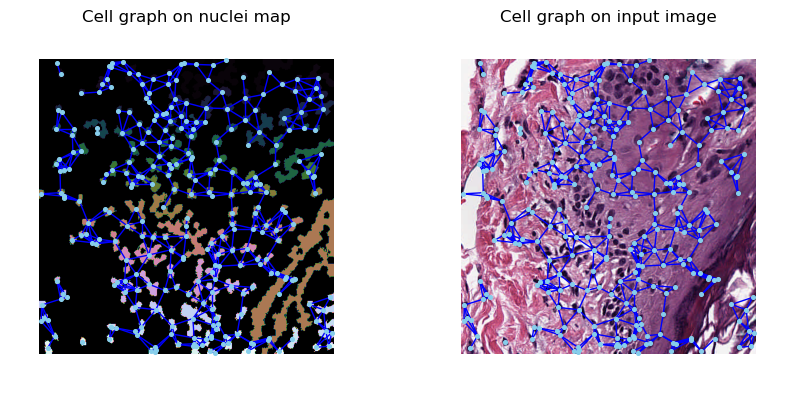

In [7]:
def plot_graph_on_image(ax, graph, image):
    from torch_geometric.utils.convert import to_networkx
    pos = graph.node_centroids.numpy()
    G = to_networkx(graph, to_undirected=True)    
    ax.imshow(image, cmap='cubehelix')
    nx.draw(G, pos, ax=ax, node_size=7, with_labels=False, font_size=8, font_color='white', node_color='skyblue', edge_color='blue')
    ax.set_facecolor('black')
    ax.set_xticks([])
    ax.set_yticks([])    
    return ax

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 10))
plot_graph_on_image(ax1, cell_graph, label_instance_map)
ax1.set_title('Cell graph on nuclei map')
plot_graph_on_image(ax2, cell_graph, image)
ax2.set_title('Cell graph on input image')
plt.show()

## Tissue detection and feature extraction

Next, we detect tissues with the help of the Region Adjacency Graphs (RAGs) method. This method iteratively merges neighbouring pixels with similar intensity using RAG and creates superpixels that correspond to tissue regions. 

We then use the feature extractor class to compute features for each detected tissue. 

In [8]:
# Initialize tissue detector and apply
tissue_detector = ColorMergedSuperpixelExtractor(superpixel_size=150,
                                                 compactness=20,
                                                 blur_kernel_size=1,
                                                 threshold=0.05,
                                                 downsampling_factor=4)

superpixels, _ = tissue_detector.process(image)

In [9]:
# initialize a feature extractor object and apply
tissue_feature_extractor = DeepPatchFeatureExtractor(architecture='resnet34',
                                                     patch_size=144,
                                                     entity = 'tissue',
                                                     resize_size=224,
                                                     fill_value=255,
                                                     batch_size=32,
                                                     device=device,
                                                     threshold = 0.25)

features = tissue_feature_extractor.process(image, superpixels)

  0%|          | 0/1 [00:00<?, ?it/s]

## Tissue-graph Construction 

We now construct the tissue graphs using our computed tissue superpixels using the RAGs method.

In [10]:
rag_graph_builder = RAGGraphBuilder(add_loc_feats=True)
tissue_graph = rag_graph_builder.process(superpixels, features, target = 0)

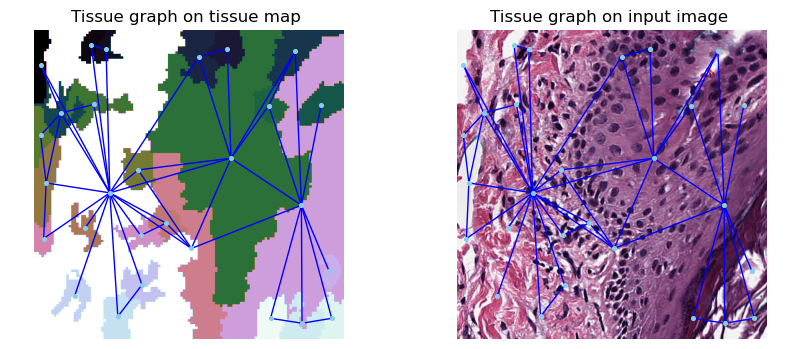

In [11]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 10))
plot_graph_on_image(ax1, tissue_graph, superpixels)
ax1.set_title('Tissue graph on tissue map')
plot_graph_on_image(ax2, tissue_graph, image)
ax2.set_title('Tissue graph on input image')
plt.show()

## (Optional) Creating an assignment matrix

Finally, we can create an assignment matrix that maps each detected cell to the tissue the cell is a part of. This is useful for trainind deep-learning models that require such hierarchical information. 

In [12]:
assignment = build_assignment_matrix(instance_centroids, superpixels)

## Putting it all together

For simplicity, we provide a general framework to the detect cells and tissues, compute features, construct and save graphs, build and save assignment matrices for all WSIs in a given directory if you are using the the [BRACS dataset](https://www.bracs.icar.cnr.it/download/).

In [13]:
# Convert the tumor time given in the filename to a label
TUMOR_TYPE_TO_LABEL = {
    'N': 0,
    'PB': 1,
    'UDH': 2,
    'ADH': 3,
    'FEA': 4,
    'DCIS': 5,
    'IC': 6
}

# Define minimum and maximum pixels for processing a WSI
MIN_NR_PIXELS = 50000
MAX_NR_PIXELS = 50000000  

# Define the patch size for applying pathml.transforms.NucleusDetectionHE 
PATCH_SIZE = 512

Next, we write the main preprocessing loop as a function. 

In [14]:
def is_valid_image(nr_pixels):
    """
    Checks if image does not exceed maximum number of pixels or exceeds minimum number of pixels.

    Args:
        nr_pixels (int): Number of pixels in given image
    """

    if nr_pixels > MIN_NR_PIXELS and nr_pixels < MAX_NR_PIXELS:
        return True
    return False

def does_exists(cg_out, tg_out, assign_out, overwrite):
    """
    Checks if given input files exist or not

    Args:
        cg_out (str): Cell graph file
        tg_out (str): Tissue graph file
        assign_out (str): Assignment matrix file
        overwrite (bool): Whether to overwrite files or not. If true, this function return false and files are
                          overwritten.
    """
    if overwrite:
        return False
    else:
        if (
            os.path.isfile(cg_out)
            and os.path.isfile(tg_out)
            and os.path.isfile(assign_out)
        ):
            return True
        return False

def process(image_path, save_path, split, plot=True, overwrite=False):
    # 1. get image path
    subdirs = os.listdir(image_path)
    image_fnames = []
    for subdir in (subdirs + ['']):  
        image_fnames += glob(os.path.join(image_path, subdir, '*.png'))
        
    image_ids_failing = []
    
    print('*** Start analysing {} image(s) ***'.format(len(image_fnames)))
    for image_path in tqdm(image_fnames):
        
        # a. load image & check if already there 
        _, image_name = os.path.split(image_path)
        image = np.array(Image.open(image_path))

        # Compute number of pixels in image and check the label of the image
        nr_pixels = image.shape[0] * image.shape[1]
        image_label = TUMOR_TYPE_TO_LABEL[image_name.split('_')[2]]

        # Get the output file paths of cell graphs, tissue graphs and assignment matrices
        cg_out = os.path.join(save_path, 'cell_graphs', split, image_name.replace('.png', '.pt'))
        tg_out = os.path.join(save_path, 'tissue_graphs', split, image_name.replace('.png', '.pt'))
        assign_out = os.path.join(save_path, 'assignment_matrices', split, image_name.replace('.png', '.pt')) 

        # If file was not already created or not too big or not too small, then process 
        if not does_exists(cg_out, tg_out, assign_out, overwrite) and is_valid_image(nr_pixels):

            print(f'Image name: {image_name}')
            print(f'Image size: {image.shape[0], image.shape[1]}')

            if plot:
                print('Input ROI:')
                plt.imshow(image)
                plt.show()
            
            try:
                # Read the image as a pathml.core.SlideData class
                print('Reading image')
                wsi = HESlide(image_path, name = image_path, backend = "openslide", stain = 'HE')

                # Apply our HoverNetNucleusDetectionHE as a pathml.preprocessing.Pipeline over all patches
                print('Detecting nuclei')
                pipeline = Pipeline([NucleusDetectionHE(mask_name = "detect_nuclei", stain_estimation_method="macenko")])
                
                # Run the Pipeline 
                wsi.run(pipeline, overwrite_existing_tiles=True, distributed=False, tile_pad=True, tile_size=PATCH_SIZE)

                # Extract the ROI, nuclei instance maps as an np.array from a pathml.core.SlideData object
                image, nuclei_map, nuclei_centroid = get_full_instance_map(wsi, patch_size = PATCH_SIZE, mask_name="detect_nuclei")

                # Use a ResNet-34 to extract the features from each detected cell in the ROI
                print('Extracting features from cells')
                extractor = DeepPatchFeatureExtractor(patch_size=64, 
                                            batch_size=64, 
                                            entity = 'cell',
                                            architecture='resnet34', 
                                            fill_value=255, 
                                            resize_size=224,
                                            device=device,
                                            threshold=0)
                features = extractor.process(image, nuclei_map)

                # Build a kNN graph with nodes as cells, node features as ResNet-34 computed features, and edges within
                # a threshold of 50
                print('Building graphs')
                knn_graph_builder = KNNGraphBuilder(k=5, thresh=50, add_loc_feats=True)
                cell_graph = knn_graph_builder.process(nuclei_map, features, target = image_label)

                # Plot cell graph on ROI image 
                if plot:
                    print('Cell graph on ROI:')
                    plot_graph_on_image(cell_graph, image)

                # Save the cell graph 
                torch.save(cell_graph, cg_out)

                # Detect tissue using pathml.graph.ColorMergedSuperpixelExtractor class
                print('Detecting tissue')
                tissue_detector = ColorMergedSuperpixelExtractor(superpixel_size=200,
                                                                 compactness=20,
                                                                 blur_kernel_size=1,
                                                                 threshold=0.05,
                                                                 downsampling_factor=4)

                superpixels, _ = tissue_detector.process(image)

                # Use a ResNet-34 to extract the features from each detected tissue in the ROI
                print('Extracting features from tissues')
                tissue_feature_extractor = DeepPatchFeatureExtractor(architecture='resnet34',
                                                                       patch_size=144,
                                                                       entity = 'tissue',
                                                                       resize_size=224,
                                                                       fill_value=255,
                                                                       batch_size=32,
                                                                       device=device,
                                                                       threshold = 0.25)
                features = tissue_feature_extractor.process(image, superpixels)

                # Build a RAG with tissues as nodes, node features as ResNet-34 computed features, and edges using the 
                # RAG algorithm
                print('Building graphs')
                rag_graph_builder = RAGGraphBuilder(add_loc_feats=True)
                tissue_graph = rag_graph_builder.process(superpixels, features, target = image_label)

                # Plot tissue graph on ROI image
                if plot:
                    print('Tissue graph on ROI:\n')
                    plot_graph_on_image(tissue_graph, image)

                # Save the tissue graph 
                torch.save(tissue_graph, tg_out)  

                # Build as assignment matrix that maps each cell to the tissue it is a part of 
                assignment = build_assignment_matrix(nuclei_centroid, superpixels)

                # Save the assignment matrix
                torch.save(torch.tensor(assignment), assign_out)
          
            except:
                print(f'Failed {image_path}')
                image_ids_failing.append(image_path)
    
    print('\nOut of {} images, {} successful graph generations.'.format(
            len(image_fnames),
            len(image_fnames) - len(image_ids_failing)
        ))
    print('Failing IDs are:', image_ids_failing)


Finally, we write a main function that calls the process function for a specified root and output directory, along with the name of the split (either train, test or validation if using BRACS). 

In [15]:
def main(base_path, save_path, split=None):
    if split is not None:
        root_path = os.path.join(base_path, split)
    else:
        root_path = base_path
    
    print(root_path)
    
    os.makedirs(os.path.join(save_path, 'cell_graphs', split), exist_ok=True)
    os.makedirs(os.path.join(save_path, 'tissue_graphs', split), exist_ok=True)
    os.makedirs(os.path.join(save_path, 'assignment_matrices', split), exist_ok=True)
    
    process(root_path, save_path, split, plot=False, overwrite=True)

In [16]:
import warnings
warnings.filterwarnings("ignore")

# Folder containing all WSI images
base = '../data/'

# Output path 
save_path = '../data/output/'

# Start preprocessing
main(base, save_path, split='train')

../../data/BRACS_RoI/latest_version/train
*** Start analysing 3657 image(s) ***


  0%|                                                                                     | 0/3657 [00:00<?, ?it/s]

Image name: BRACS_1238_FEA_56.png
Image size: (751, 1050)
Reading image
Detecting nuclei
Extracting features from cells


  0%|          | 0/4 [00:00<?, ?it/s]

Building graphs
Detecting tissue
Extracting features from tissues


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|                                                                                     | 0/3657 [00:15<?, ?it/s]

Building graphs

Out of 3657 images, 3657 successful graph generations.
Failing IDs are: []


## References

*  Pati, Pushpak, Guillaume Jaume, Antonio Foncubierta-Rodriguez, Florinda Feroce, Anna Maria Anniciello, Giosue Scognamiglio, Nadia Brancati et al. "Hierarchical graph representations in digital pathology." Medical image analysis 75 (2022): 102264.
*  Brancati, Nadia, Anna Maria Anniciello, Pushpak Pati, Daniel Riccio, Giosuè Scognamiglio, Guillaume Jaume, Giuseppe De Pietro et al. "Bracs: A dataset for breast carcinoma subtyping in h&e histology images." Database 2022 (2022): baac093.